In [1]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [27]:
# Annotations structure
file = './datasets/Room_all_agents/Room1/Setting1/8m/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.499364,0.000094,0.117077,2.107222,-0.783901,True,6.918802,0.082890,True,6.357754,0.892982,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.497246,0.000766,0.395836,1.800532,-1.312243,True,6.669603,-1.835180,True,6.347177,-0.898825,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.485843,0.007717,0.725341,1.269790,-1.777184,False,5.684648,-3.913701,True,5.676816,-2.914395,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.475703,0.019575,1.031016,0.675467,-2.030959,False,4.195889,-5.452686,True,4.486544,-4.485341,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.466661,0.039314,1.287408,0.139663,-2.092604,False,2.620631,-6.332658,False,3.149596,-5.458576,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [21]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/Room_all_agents/Room*'))+1):
    room_dir = f'./datasets/Room_all_agents/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'

        for agent_dir in glob(f'{set_dir}/*'):
            agent = agent_dir.split('/')[-1]

            for ep in range(1, len(glob(f'{agent_dir}/episode_*'))+1):     

                ep_dir = f'{agent_dir}/episode_{ep:04}'
                try:
                    with open(f'{ep_dir}/episode_{ep:04}.pkl', 'rb') as f:
                        df = pickle.load(f)

                        if ep not in df['episode'].unique():
                            print(f'[WARN] Fixed episode in DataFrame {ep_dir}/{ep:04}.pkl not matching the name of the directory.')
                            df['episode'] =  np.ones(df.shape[0], dtype=int) * ep

                        df.insert(0, 'agent', [agent for _ in range(df.shape[0])])
                        df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                        df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                        ep_dfs.append(df)
                except FileNotFoundError:
                    print(f'[WARN] File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

[WARN] Fixed episode in DataFrame ./datasets/Room_all_agents/Room1/Setting3/8m/episode_0005/0005.pkl not matching the name of the directory.
[WARN] Fixed episode in DataFrame ./datasets/Room_all_agents/Room1/Setting4/8m/episode_0005/0005.pkl not matching the name of the directory.
[WARN] Fixed episode in DataFrame ./datasets/Room_all_agents/Room1/Setting5/8m/episode_0005/0005.pkl not matching the name of the directory.


,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,6000000,1,1,2.5,0.0,-2.511899,-0.000324,0.064005,...,0.971636,-5.042394,False,0.939695,-2.672393,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,6000000,1,2,2.5,0.0,-2.538352,-0.003958,0.220937,...,0.202131,-5.149991,False,0.542664,-2.781755,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,6000000,1,3,2.5,0.0,-2.564896,-0.012329,0.437258,...,-0.881970,-5.099983,False,-0.024519,-2.821527,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,6000000,1,4,2.5,0.0,-2.581863,-0.022204,0.718748,...,-2.253910,-4.679027,False,-0.768752,-2.690010,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,6000000,1,5,2.5,0.0,-2.578010,-0.015496,1.005735,...,-3.509466,-3.866783,False,-1.486116,-2.346344,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [22]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/Room_all_agents/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/Room_all_agents/annotations.pkl')

# 2. Image Analysis

In [33]:
file = './datasets/Room_all_agents/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    ep_dfs = ep_dfs[ep_dfs['room'] == 2]
    ep_dfs.reset_index(inplace=True, drop=True)
    display(ep_dfs.head())

print(f"Number of records: {ep_dfs.shape[0]}")

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of records: 8753


In [34]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
agent = anchor_rec['agent']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('2', '1', '0002', '00169')

In [35]:
anchor_rec

room                                                                 2
setting                                                              1
agent                                                           400000
episode                                                              2
step                                                               169
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                  -1.970844
robot_pos_y                                                   0.304336
robot_yaw                                                     0.583537
robot_1_rel_pos_x                                             1.923866
robot_1_rel_pos_y                                            -0.012107
robot_1_in_fov                                                    True
robot_2_rel_pos_x                                            -2.369772
robot_

In [36]:
# Look for positive examples in either other rooms or settings or other agents
pos_df = ep_dfs[(ep_dfs['room'] != anchor_rec['room']) | (ep_dfs['setting'] != anchor_rec['setting']) | (ep_dfs['agent'] != anchor_rec['agent'])].copy()
pos_df

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,2,3,8m,5,86,2.5,0.0,1.940749,0.103740,-0.132197,...,-6.194475,-2.927711,False,-5.179220,-4.400761,False,"{'scan': [[0.13120943], [0.1346703], [0.138357...",9.0,10.0,11.0
8749,2,3,8m,5,87,2.5,0.0,1.991763,0.096320,-0.157763,...,-6.163866,-3.083260,False,-5.137458,-4.532350,False,"{'scan': [[0.14208236], [0.14566554], [0.14947...",9.0,10.0,11.0
8750,2,3,8m,5,88,2.5,0.0,2.042558,0.087611,-0.183483,...,-6.128777,-3.235537,False,-5.091092,-4.658668,False,"{'scan': [[0.15766236], [0.16162385], [0.16583...",9.0,10.0,11.0
8751,2,3,8m,5,89,2.5,0.0,2.093258,0.077597,-0.207789,...,-6.097354,-3.377372,False,-5.046530,-4.772039,False,"{'scan': [[0.16784842], [0.17175904], [0.17591...",9.0,10.0,11.0


In [37]:
# Look for negative examples in other episodes of the same setting of the room
neg_df = ep_dfs[(ep_dfs['room'] == anchor_rec['room']) & (ep_dfs['setting'] == anchor_rec['setting']) & ((ep_dfs['episode'] != anchor_rec['episode']) | (ep_dfs['agent'] != anchor_rec['agent']))].copy()
neg_df

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,2,1,8m,5,107,2.5,0.0,2.489289,0.509339,-0.841457,...,1.426331,-2.988609,False,3.798527,-0.381165,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3178,2,1,8m,5,108,2.5,0.0,2.521469,0.471775,-0.885632,...,1.515599,-2.933292,False,3.767872,-0.226590,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3179,2,1,8m,5,109,2.5,0.0,2.552459,0.432503,-0.923080,...,1.578644,-2.887142,False,3.733020,-0.095891,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3180,2,1,8m,5,110,2.5,0.0,2.581659,0.392362,-0.963327,...,1.644339,-2.832132,False,3.696884,0.047760,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


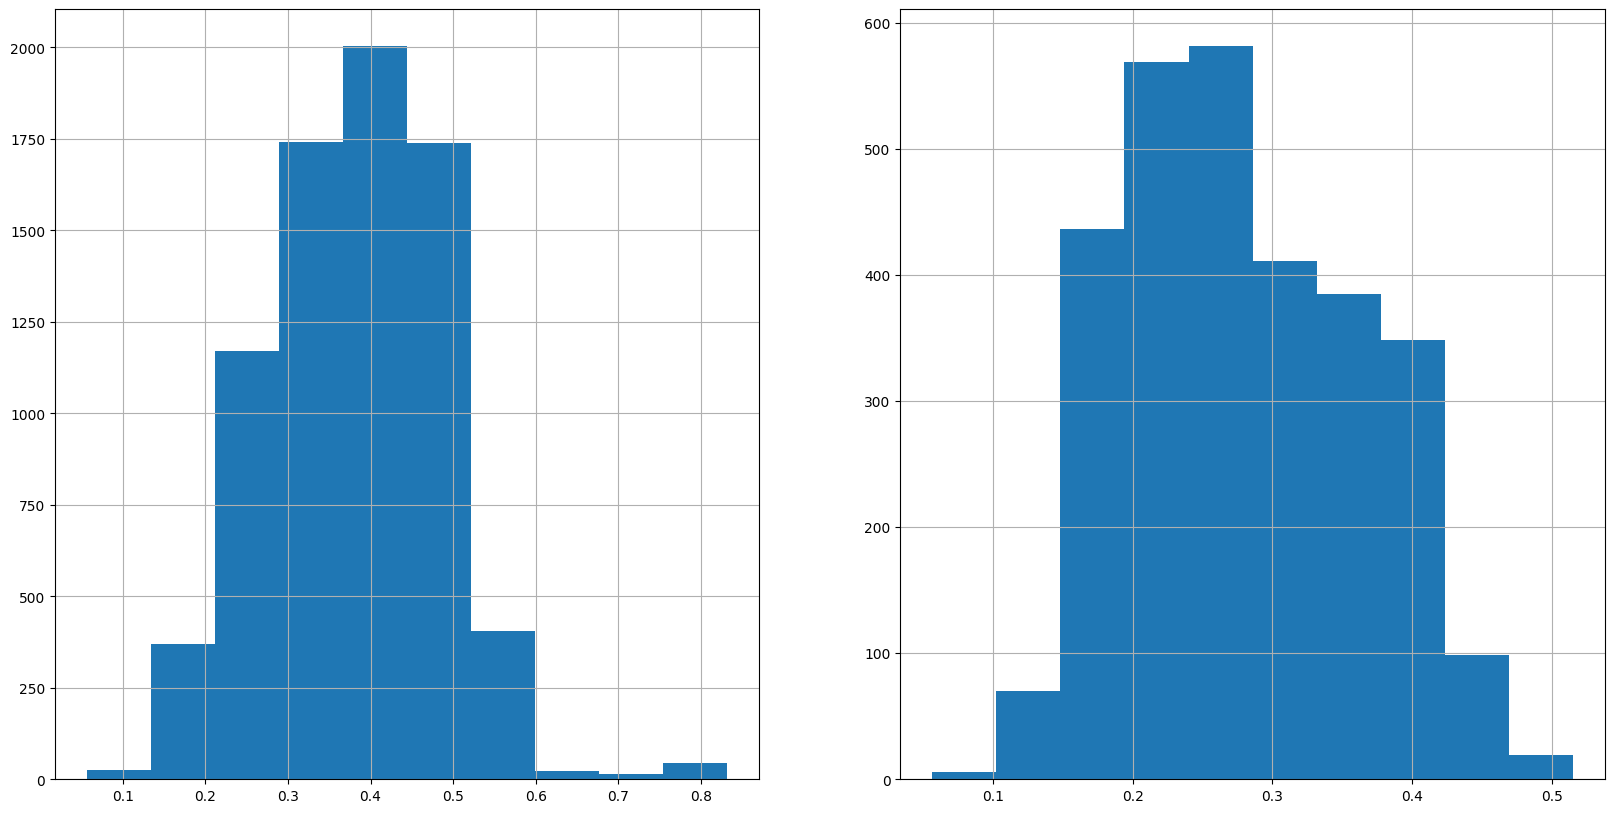

In [38]:
# Weight vector
anc_scan = anchor_rec.laser_readings['scan'].squeeze()
w = np.zeros(anc_scan.shape[0])
# In FOV readings (consider only them for binary masking)
w[64:164] += 1 
# Out of FOV readings (consider also them for soft masking)
x = np.linspace(0.0, 1.0, w[164:].shape[0])
sigmoid = 1 - 0.9*(1 / (1+np.exp(-x))) # Sigmoid 1.0 -> 0.1
w[164:] += sigmoid
w[63::-1] += sigmoid

# Normalizer
den = np.sqrt(w.sum())

# Normalized weighted Eucledian distances on LiDAR readings 
pos_l2_dist = pos_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)
neg_l2_dist = neg_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_l2_dist.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_l2_dist.hist(ax=bx);

-5 -5


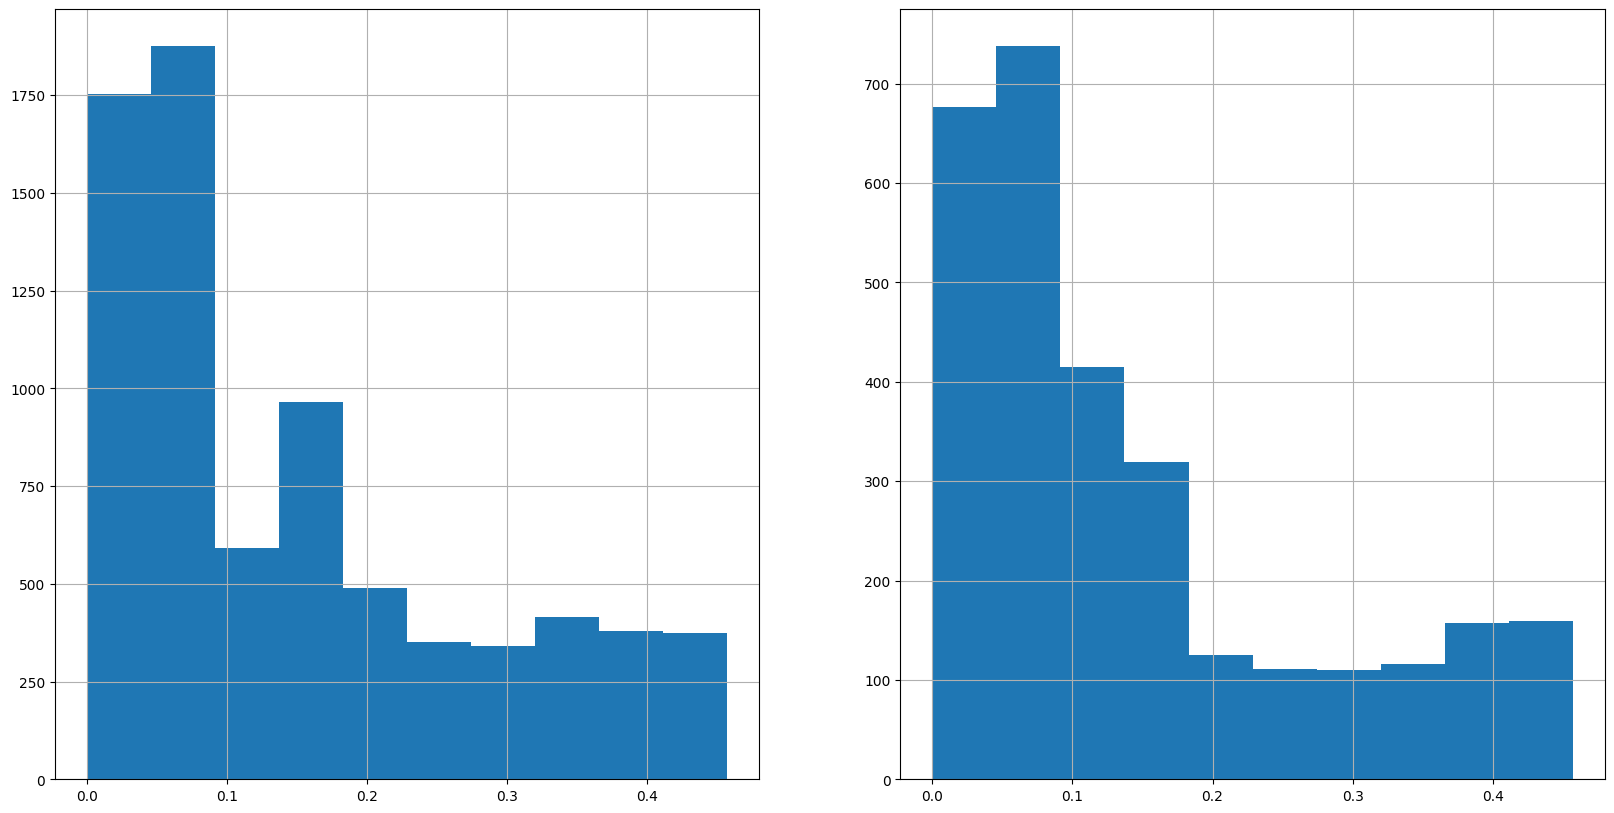

In [39]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
pos_gd_diffs = pos_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd 
neg_gd_diffs = neg_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_gd_diffs.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_gd_diffs.hist(ax=bx);

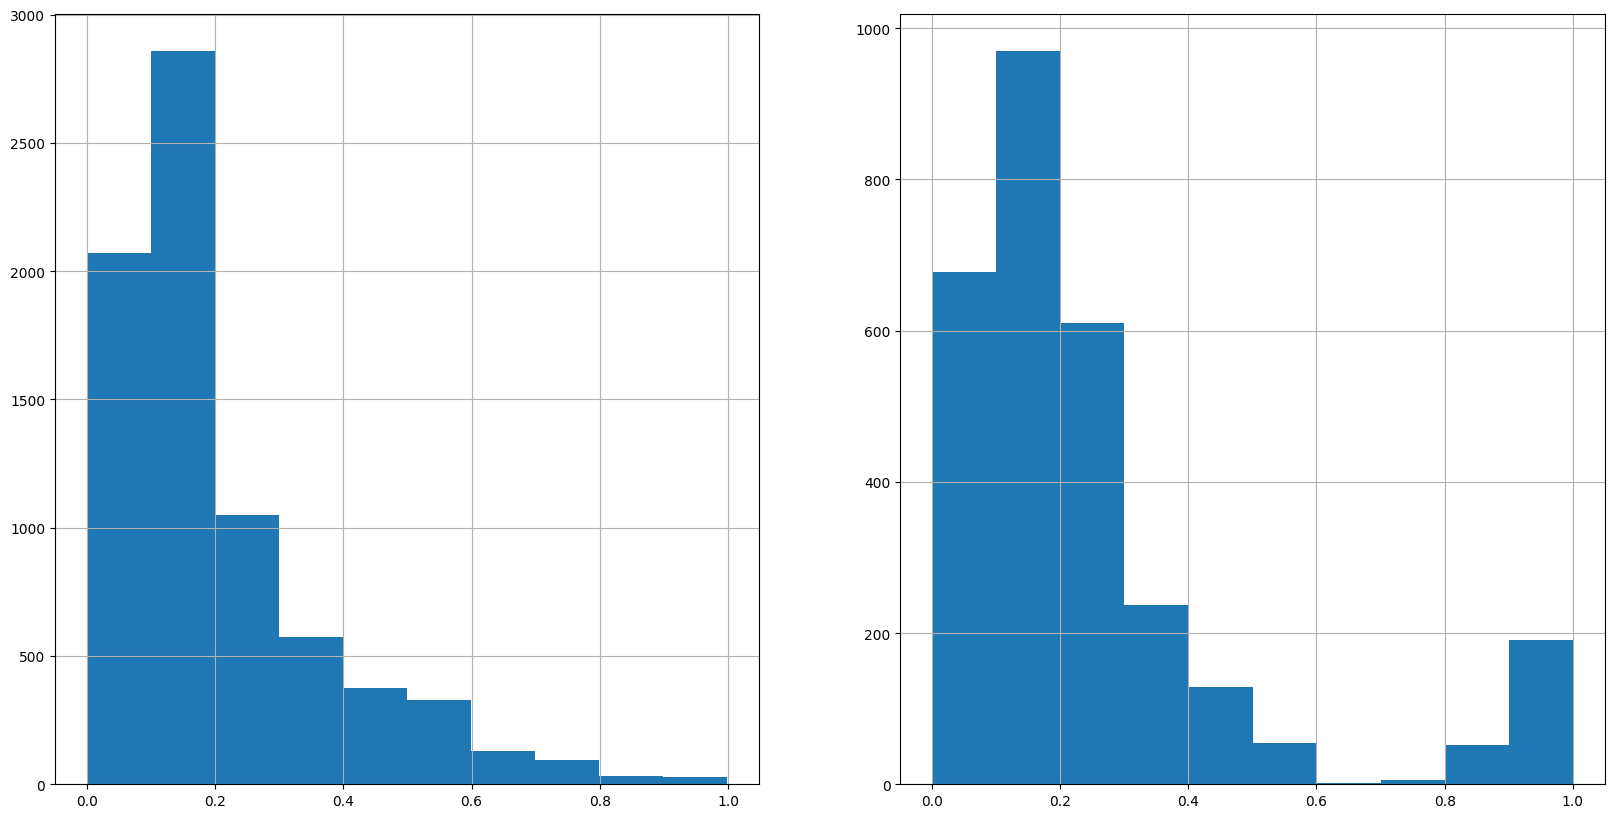

In [40]:
# Normalize angle between [-pi, pi]
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Compute angle with respect to the goal considering robot's orientation
def relative_angle(record):
    # Info
    robot_x, robot_y = record['robot_pos_x'], record['robot_pos_y']
    goal_x, goal_y = record['target_point_x'], record['target_point_y']
    theta_r = record['robot_yaw'] 

    # Relative angle
    dx = goal_x - robot_x
    dy = goal_y - robot_y
    theta_g = np.arctan2(dy, dx)
    return normalize_angle(theta_g - theta_r)

# Orientation towards goal position
anchor_phi = relative_angle(anchor_rec)
pos_ori_diff = pos_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1) 
neg_ori_diff = neg_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_ori_diff.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_ori_diff.hist(ax=bx);

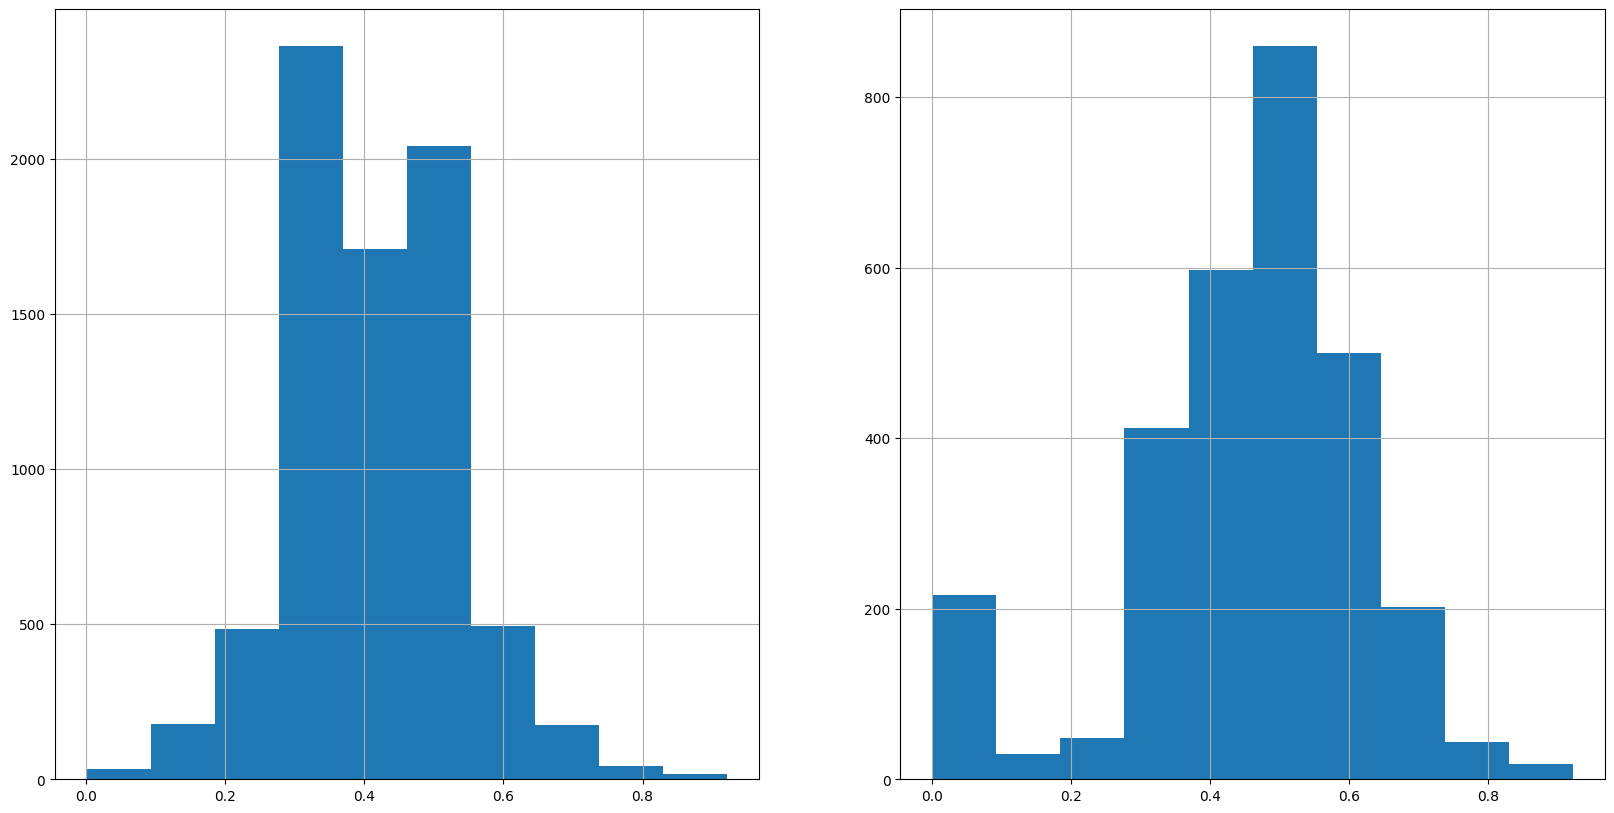

In [41]:
# Combine distances for computing similarities
pos_sim_scores = (1 - pos_l2_dist)*(1 - pos_gd_diffs)*(1 - pos_ori_diff)
neg_sim_scores = (1 - neg_l2_dist)*(1 - neg_gd_diffs)*(1 - neg_ori_diff)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_sim_scores.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_sim_scores.hist(ax=bx);

In [42]:
# Negative examples mining
BASE_NEG_DIST = 0.2
N_NEG_SAMPLES = 12

negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.05
    negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

2294    0.025813
2354    0.003968
2410    0.012086
2286    0.004827
2321    0.072821
2365    0.005333
2401    0.026018
2186    0.108645
2357    0.108905
2406    0.057743
2271    0.056914
2300    0.094033
dtype: float64

In [43]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
2294,2,1,400000,4,124,2.5,0.0,-0.785128,0.947737,-2.657722,...,-7.007021,-0.527008,False,-2.959086,4.477399,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2354,2,1,400000,4,184,2.5,0.0,-1.036323,0.866927,-2.747175,...,-6.603616,-1.150697,False,-3.751686,4.320021,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2410,2,1,400000,4,240,2.5,0.0,-1.191433,0.829499,-2.760815,...,-6.729222,-0.901415,False,-3.678811,4.351375,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2286,2,1,400000,4,116,2.5,0.0,-0.801638,0.928158,-2.785062,...,-6.821867,-1.327892,False,-3.564690,4.066327,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2321,2,1,400000,4,151,2.5,0.0,-0.898717,0.934248,-2.436982,...,-6.943814,1.189435,False,-1.934879,5.119921,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2365,2,1,400000,4,195,2.5,0.0,-1.059640,0.848734,-2.701699,...,-6.409292,-1.023480,False,-3.505032,4.459364,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2401,2,1,400000,4,231,2.5,0.0,-1.212667,0.811141,-2.811504,...,-6.800967,-1.177439,False,-3.854431,4.084170,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2186,2,1,400000,4,16,2.5,0.0,-2.365654,-0.211862,-2.872948,...,-7.906185,-3.424373,False,-6.114057,1.651301,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2357,2,1,400000,4,187,2.5,0.0,-0.988273,0.904979,-2.265447,...,-6.243796,1.957223,False,-1.266540,5.533457,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2406,2,1,400000,4,236,2.5,0.0,-1.183217,0.831677,-2.469665,...,-6.765447,1.109853,False,-2.226516,5.164085,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [44]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_agent = neg_rec['agent']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/Room_all_agents/Room{neg_room}/Setting{neg_set}/{neg_agent}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [45]:
# Positive examples mining
BASE_POS_DIST = 0.8
N_POS_SAMPLES = 4

positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.001
    positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

3092    0.843244
17      0.822847
15      0.817821
4       0.867258
dtype: float64

In [46]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
3092,2,1,8m,5,22,2.5,0.0,-1.609478,0.538113,0.549567,...,0.519197,-3.924971,False,3.686165,-5.404738,False,"{'scan': [[0.6199393], [0.6202478], [0.6207047...",9.0,10.0,11.0
17,2,1,6000000,1,18,2.5,0.0,-1.784787,0.377307,0.470887,...,-1.461197,-2.224256,False,-1.700813,2.018762,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15,2,1,6000000,1,16,2.5,0.0,-1.877485,0.331217,0.468790,...,-1.346682,-2.162285,False,-1.573075,2.035243,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [47]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_agent = pos_rec['agent']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/Room_all_agents/Room{pos_room}/Setting{pos_set}/{pos_agent}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

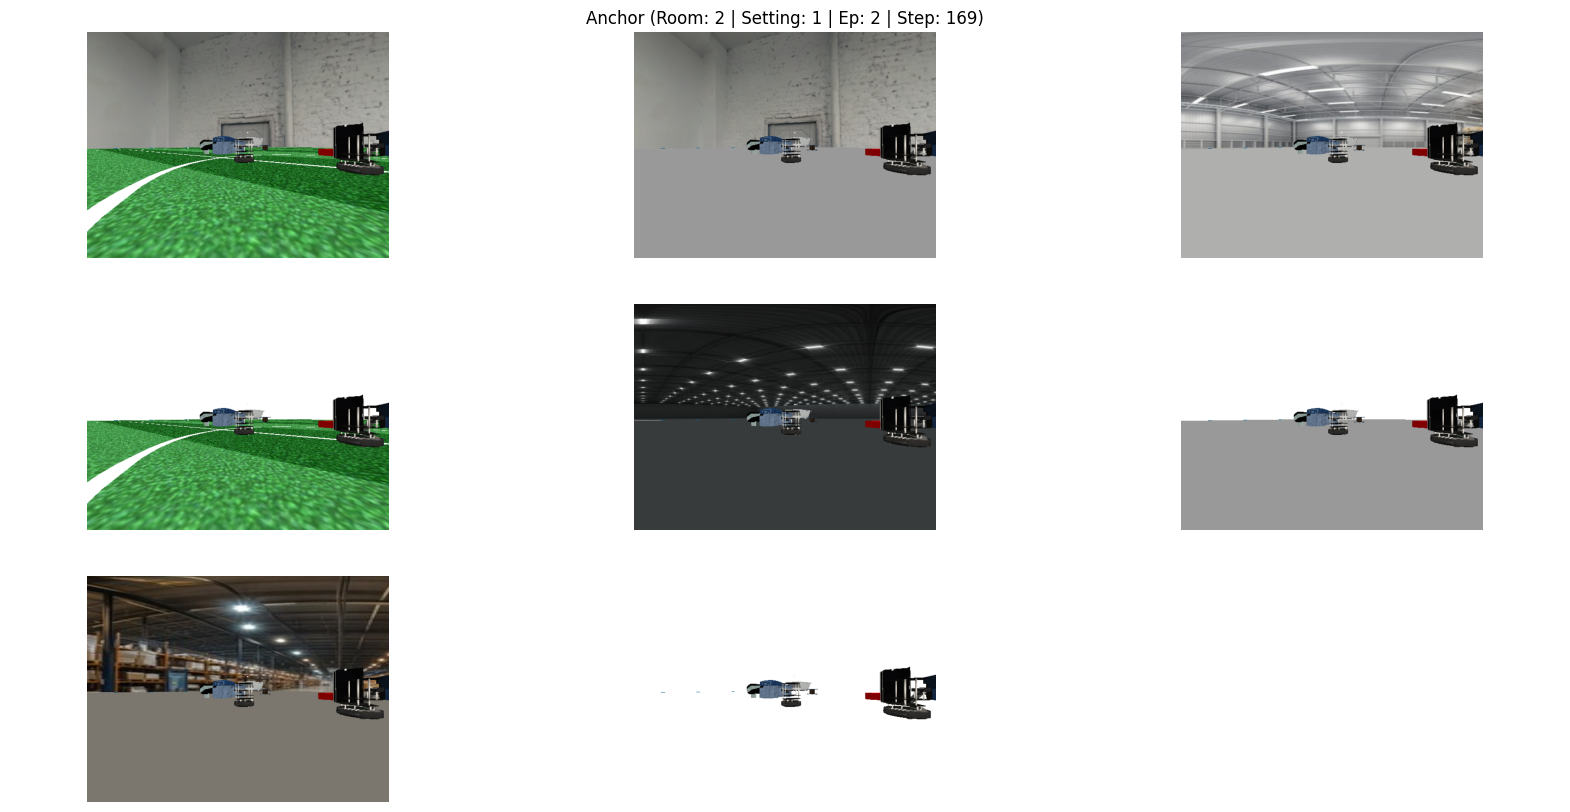

In [48]:
# Anchor image
anc_img = Image.open(f'./datasets/Room_all_agents/Room{room}/Setting{setting}/{agent}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/Room_all_agents/Room{room}/Setting{setting}/{agent}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

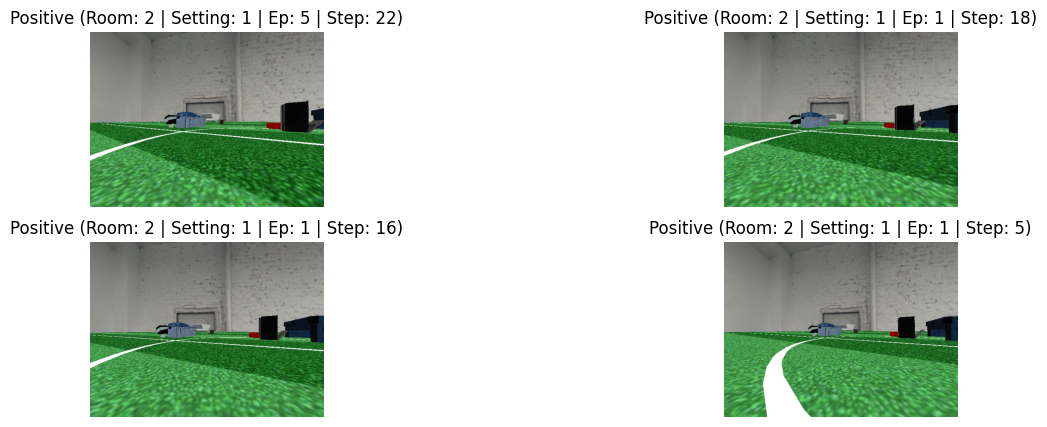

In [49]:
N_ROWS = 2
N_COLS = 2

# Plot positive examples by similarity
plt.figure(figsize=[15,5])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

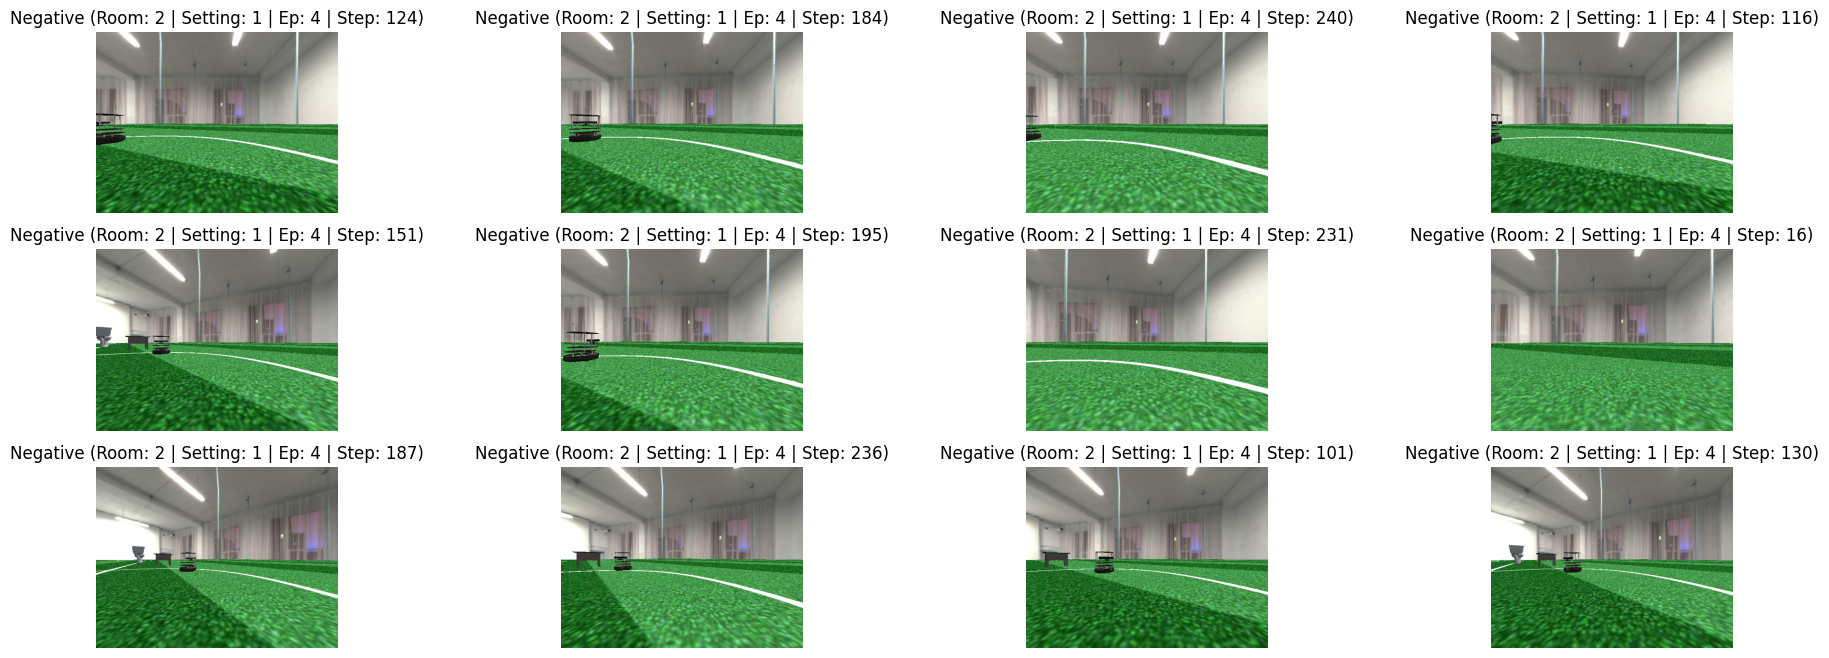

In [50]:
N_ROWS = 3
N_COLS = 4

# Plot negative examples by similarity
plt.figure(figsize=[23,8])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();